In [14]:
# --- CELL 1: IMPORT THƯ VIỆN CHO MÔ HÌNH ETS (STATSMODELS) ---

# Thư viện cơ bản cho xử lý dữ liệu và tính toán
import pandas as pd
import numpy as np

# Thư viện cho trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns # Vẫn hữu ích cho việc làm đẹp biểu đồ matplotlib

# Thư viện Scikit-learn CHỈ cho các độ đo đánh giá
from sklearn.metrics import r2_score # Sử dụng r2_score của sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Thư viện Statsmodels cho mô hình ETS và các tiện ích chuỗi thời gian
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt # Các lớp ETS cụ thể
# from statsmodels.tsa.ets.api import ETSModel # Bỏ comment nếu statsmodels đủ mới và muốn dùng ETSModel tổng quát
from statsmodels.tsa.stattools import adfuller # Có thể dùng để kiểm tra tính dừng (mặc dù ETS ít yêu cầu hơn ARIMA)
from statsmodels.graphics.tsaplots import plot_acf # Để phân tích phần dư
import statsmodels.api as sm # Cho Q-Q plot, kiểm định Ljung-Box
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
# Cài đặt cho Matplotlib để hiển thị biểu đồ ngay trong notebook
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler # Hoặc StandardScaler
import xgboost as xgb
# Cài đặt cho Pandas để hiển thị số float (tùy chọn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# In thông báo hoàn tất
print("\n--- Cell 1: Import Thư viện cho Mô hình ETS Hoàn Tất ---")
print("Các thư viện cần thiết cho Exponential Smoothing (ETS) đã được import.")


--- Cell 1: Import Thư viện cho Mô hình ETS Hoàn Tất ---
Các thư viện cần thiết cho Exponential Smoothing (ETS) đã được import.


In [15]:
# --- CELL 2: ĐỌC, TIỀN XỬ LÝ VÀ THỐNG KÊ DỮ LIỆU (KHÔNG VẼ BIỂU ĐỒ EDA) ---
print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---")

# --- 2.1. THU THẬP DỮ LIỆU ---
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path)
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0, '']) # '' xử lý ô trống
except FileNotFoundError: print(f"Lỗi: Không tìm thấy file '{file_path}'."); raise
except Exception as e: print(f"Lỗi khi đọc file CSV: {e}"); raise
print("2.1. Đọc dữ liệu thô thành công.")

print("\n--- Thông tin DataFrame df_raw_initial (Đọc thô) ---")
if 'df_raw_initial' in locals():
    print(f"Kích thước: {df_raw_initial.shape[0]} hàng, {df_raw_initial.shape[1]} cột.")
    with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False): # Tóm tắt hơn
        display(df_raw_initial) # Pandas sẽ tự tóm tắt nếu lớn
    df_raw_initial.info(memory_usage=False, verbose=False)
else: print("df_raw_initial chưa được tạo.")

# --- 2.2. XÁC ĐỊNH BIẾN MỤC TIÊU ---
print("\n--- 2.2. Xác định Biến Mục tiêu ---")
print("Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.")

# --- 2.3. TIỀN XỬ LÝ DỮ LIỆU ---
print("\n--- 2.3. Tiền xử lý dữ liệu ---")
df_raw.dropna(how='all', inplace=True)
rows_before_footer = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF|World Economic Outlook Database|Data source:", na=False, case=False, regex=True)]
print(f"  2.3.1.1. Làm sạch: Loại bỏ {rows_before_footer - len(df_raw)} dòng footer/ghi chú.")
df_raw.rename(columns={df_raw.columns[0]: 'Country Name'}, inplace=True)
df_raw.dropna(subset=['Country Name'], inplace=True)
df_raw.reset_index(drop=True, inplace=True)
print("  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.")
print(f"  df_raw sau làm sạch cơ bản: {df_raw.shape[0]} hàng, {df_raw.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False):
    display(df_raw.head(3)) # Chỉ hiển thị 3 dòng đầu

print("\n  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---")
year_columns_global = df_raw.columns[1:]
df_raw_eda_stats_global = df_raw.copy()
for col in year_columns_global:
    df_raw_eda_stats_global[col] = pd.to_numeric(df_raw_eda_stats_global[col], errors='coerce')
missing_yearly_stats_global = df_raw_eda_stats_global[year_columns_global].isnull().sum()
print(f"\n    Tổng NaN theo năm (Top 3):"); display(missing_yearly_stats_global.sort_values(ascending=False).head(3).to_frame(name='Số NaN'))
if len(year_columns_global) > 0:
    sample_years_stats_global = [str(year_columns_global[0]), str(year_columns_global[len(year_columns_global)//2]), str(year_columns_global[-1])]
    existing_sample_years_global = [yr for yr in sample_years_stats_global if yr in df_raw_eda_stats_global.columns]
    if existing_sample_years_global:
        print(f"\n    Thống kê GDP cho các năm ({', '.join(existing_sample_years_global)}):"); display(df_raw_eda_stats_global[existing_sample_years_global].describe().T.head(3)) # Transpose và head
    last_year_stats_global = str(year_columns_global[-1])
    if last_year_stats_global in df_raw_eda_stats_global.columns:
        print(f"\n    Top 3 GDP cao nhất năm {last_year_stats_global}:")
        display(df_raw_eda_stats_global[['Country Name', last_year_stats_global]].sort_values(by=last_year_stats_global, ascending=False).head(3).reset_index(drop=True))

# --- 2.5. CHUYỂN ĐỔI DỮ LIỆU ---
print("\n--- 2.5. Chuyển đổi dữ liệu ---")
print("  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---")
try:
    df_long = pd.melt(df_raw, id_vars=['Country Name'], var_name='Year', value_name='GDP')
except KeyError as e: print(f"Lỗi melt: {e}"); raise
print(f"  Chuyển đổi wide sang long thành công. df_long: {df_long.shape[0]} hàng, {df_long.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.show_dimensions', False): display(df_long)

print("\n  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---")
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object': df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.")
rows_before_final_dropna_long = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
print(f"  Xử lý NaN cuối cùng trong df_long: Loại bỏ {rows_before_final_dropna_long - len(df_long)} dòng.")

print("\n  --- 2.5.3. Sắp xếp dữ liệu df_long ---")
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long['Year'] = df_long['Year'].astype(int)
df_long.reset_index(drop=True, inplace=True)
print("  Sắp xếp df_long và chuyển Year về int hoàn tất.")

# --- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long cuối cùng) ---
print("\n\n--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---")
if 'df_long' in locals() and not df_long.empty:
    print(f"Kích thước cuối cùng: {df_long.shape[0]} hàng × {df_long.shape[1]} cột.")
    print(f"Tên cột: {df_long.columns.tolist()}"); print("\nKiểu dữ liệu:"); print(df_long.dtypes)
    print("\nGiá trị duy nhất/cột:");
    for col in df_long.columns: print(f"  - {col}: {df_long[col].nunique()}")
    print("\nKiểm tra NaN:"); print(df_long.isnull().sum())
    print("\nThống kê mô tả:"); display(df_long.describe())
    print(f"\nPhạm vi năm: {df_long['Year'].min()} - {df_long['Year'].max()}")
    print(f"Số quốc gia: {df_long['Country Name'].nunique()}")
    print(f"Số năm dữ liệu TB/quốc gia: {df_long.groupby('Country Name')['Year'].count().mean():.2f}")
    print("\nHiển thị tóm tắt df_long cuối cùng:")
    with pd.option_context('display.max_rows', 10, 'display.show_dimensions', True): # Hiển thị 10 dòng (5 đầu, 5 cuối)
        display(df_long)
else: print("df_long chưa được tạo hoặc rỗng.")
print("\n--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---")

--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---
2.1. Đọc dữ liệu thô thành công.

--- Thông tin DataFrame df_raw_initial (Đọc thô) ---
Kích thước: 230 hàng, 45 cột.


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,...,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254
...,...,...,...,...,...,...,...,...,...,...,...
227,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
229,"©IMF, 2022",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Columns: 45 entries, GDP, current prices (Billions of U.S. dollars) to 2023
dtypes: float64(44), object(1)
--- 2.2. Xác định Biến Mục tiêu ---
Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.

--- 2.3. Tiền xử lý dữ liệu ---
  2.3.1.1. Làm sạch: Loại bỏ 1 dòng footer/ghi chú.
  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.
  df_raw sau làm sạch cơ bản: 196 hàng, 45 cột.


,Country Name,1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,...,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254



  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---

    Tổng NaN theo năm (Top 3):


,Số NaN
1980,50
1982,50
1983,50



    Thống kê GDP cho các năm (1980, 2002, 2023):


,count,mean,std,min,25%,50%,75%,max
1980,146.000,76.974,275.705,0.032,1.921,6.967,40.359,2857.325
2002,193.000,180.909,878.732,0.017,2.257,9.719,70.282,10929.100
2023,190.000,556.407,2427.762,0.068,10.902,43.337,270.734,26185.210



    Top 3 GDP cao nhất năm 2023:


,Country Name,2023
0,United States,26185.210
1,"China, People's Republic of",19243.974
2,Japan,4365.976



--- 2.5. Chuyển đổi dữ liệu ---
  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---
  Chuyển đổi wide sang long thành công. df_long: 8624 hàng, 3 cột.


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
...,...,...,...
8621,Yemen,2023,28.099
8622,Zambia,2023,28.798
8623,Zimbabwe,2023,37.303



  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---
  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.
  Xử lý NaN cuối cùng trong df_long: Loại bỏ 772 dòng.

  --- 2.5.3. Sắp xếp dữ liệu df_long ---
  Sắp xếp df_long và chuyển Year về int hoàn tất.


--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---
Kích thước cuối cùng: 7852 hàng × 3 cột.
Tên cột: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu:
Country Name     object
Year              int32
GDP             float64
dtype: object

Giá trị duy nhất/cột:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra NaN:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả:


,Year,GDP
count,7852.000,7852.000
mean,2002.742,263.121
std,12.397,1245.565
min,1980.000,0.014
25%,1993.000,3.260
50%,2003.000,15.974
75%,2013.000,99.016
max,2023.000,26185.210



Phạm vi năm: 1980 - 2023
Số quốc gia: 196
Số năm dữ liệu TB/quốc gia: 40.06

Hiển thị tóm tắt df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925
...,...,...,...
7847,Zimbabwe,2019,22.995
7848,Zimbabwe,2020,23.181
7849,Zimbabwe,2021,32.868
7850,Zimbabwe,2022,38.280



--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---


In [16]:
# --- CELL BR1.M8: MÔ HÌNH 8 (BAYESIAN RIDGE) - ĐỊNH NGHĨA THAM SỐ VÀ CHUẨN BỊ DỮ LIỆU ---

from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# === THAM SỐ CHUNG CHO MÔ HÌNH BAYESIAN RIDGE NÀY ===
MODEL_ID_M8 = "M8_BayesianRidge_LagsYearSq"
COUNTRY_M8 = 'Vietnam' # <<--- THAY ĐỔI QUỐC GIA Ở ĐÂY
TEST_SIZE_RATIO_M8 = 0.2
N_FUTURE_YEARS_M8 = 5
NUM_LAGS_M8 = 3 # Thử với số lags ít hơn
# Siêu tham số cho BayesianRidge thường được để mặc định để mô hình tự học
# Tuy nhiên, bạn có thể thử nghiệm với n_iter, tol, alpha_init, lambda_init nếu muốn
# =================================================

print(f"\n\n--- BẮT ĐẦU {MODEL_ID_M8} CHO {COUNTRY_M8.upper()} ---")
print(f"Sử dụng {NUM_LAGS_M8} lags, Year_Feat, Year_Sq_Feat. Dữ liệu X sẽ được chuẩn hóa.")

# 1. Lọc dữ liệu và tạo đặc trưng
X_m8, y_m8, country_data_processed_m8, feature_columns_m8, country_data_br_m8 = None, None, None, None, None

if 'df_long' not in locals() or df_long.empty:
    print(f"Lỗi: df_long chưa được tạo. Vui lòng chạy Cell 2.")
else:
    country_data_br_m8 = df_long[df_long['Country Name'] == COUNTRY_M8].copy()
    country_data_br_m8.sort_values('Year', inplace=True)
    country_data_br_m8.reset_index(drop=True, inplace=True)

    min_data_len_m8 = NUM_LAGS_M8 + 10 
    if country_data_br_m8.empty or len(country_data_br_m8) < min_data_len_m8:
        print(f"Không đủ dữ liệu cho '{COUNTRY_M8}' ({len(country_data_br_m8)} điểm) để xây dựng {MODEL_ID_M8}.")
    else:
        print(f"Đã lọc dữ liệu cho {COUNTRY_M8}. Số dòng ban đầu: {len(country_data_br_m8)}")
        
        feature_columns_m8 = []
        for i in range(1, NUM_LAGS_M8 + 1):
            col_name = f'GDP_lag{i}'
            country_data_br_m8[col_name] = country_data_br_m8['GDP'].shift(i)
            feature_columns_m8.append(col_name)
        
        country_data_br_m8['Year_Feat'] = country_data_br_m8['Year']
        feature_columns_m8.append('Year_Feat')
        country_data_br_m8['Year_Sq_Feat'] = country_data_br_m8['Year']**2
        feature_columns_m8.append('Year_Sq_Feat')
        
        print(f"\nĐã tạo các đặc trưng: {feature_columns_m8}.")
        
        country_data_processed_m8 = country_data_br_m8.dropna().copy()
        country_data_processed_m8.reset_index(drop=True, inplace=True)

        if len(country_data_processed_m8) < NUM_LAGS_M8 + 5: 
            print(f"Không đủ dữ liệu sau khi tạo features và dropna cho {MODEL_ID_M8}.")
        else:
            print(f"\nSố dòng dữ liệu của {COUNTRY_M8} sau khi tạo features và dropna: {len(country_data_processed_m8)}")
            y_m8 = country_data_processed_m8['GDP']
            X_m8 = country_data_processed_m8[feature_columns_m8]
            print(f"\n--- Đặc trưng X cho {MODEL_ID_M8} (3 dòng đầu) ---"); display(X_m8.head(3))



--- BẮT ĐẦU M8_BayesianRidge_LagsYearSq CHO VIETNAM ---
Sử dụng 3 lags, Year_Feat, Year_Sq_Feat. Dữ liệu X sẽ được chuẩn hóa.
Đã lọc dữ liệu cho Vietnam. Số dòng ban đầu: 44

Đã tạo các đặc trưng: ['GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'Year_Feat', 'Year_Sq_Feat'].

Số dòng dữ liệu của Vietnam sau khi tạo features và dropna: 41

--- Đặc trưng X cho M8_BayesianRidge_LagsYearSq (3 dòng đầu) ---


,GDP_lag1,GDP_lag2,GDP_lag3,Year_Feat,Year_Sq_Feat
0,23.369,17.617,35.357,1983,3932289
1,35.204,23.369,17.617,1984,3936256
2,61.171,35.204,23.369,1985,3940225


In [17]:
# --- CELL BR2.M8: {MODEL_ID_M8} - CHIA TRAIN/TEST, CHUẨN HÓA VÀ HUẤN LUYỆN ---

model_br_m8 = None 
X_train_m8, X_test_m8, y_train_m8, y_test_m8 = None, None, None, None
X_train_scaled_m8, X_test_scaled_m8 = None, None
years_train_m8, years_test_m8 = None, None
scaler_X_m8 = None 

if 'X_m8' in locals() and X_m8 is not None and \
   'y_m8' in locals() and y_m8 is not None and not X_m8.empty:
    
    split_index_m8 = int(len(X_m8) * (1 - TEST_SIZE_RATIO_M8)) # TEST_SIZE_RATIO_M8 từ cell trước
    X_train_m8, X_test_m8 = X_m8.iloc[:split_index_m8], X_m8.iloc[split_index_m8:]
    y_train_m8, y_test_m8 = y_m8.iloc[:split_index_m8], y_m8.iloc[split_index_m8:]

    # country_data_processed_m8 và feature_columns_m8 cũng cần được định nghĩa ở cell trước
    if 'country_data_processed_m8' in locals() and country_data_processed_m8 is not None:
        years_full_processed_m8 = country_data_processed_m8['Year']
        years_train_m8 = years_full_processed_m8.iloc[:split_index_m8]
        years_test_m8 = years_full_processed_m8.iloc[split_index_m8:]
    else:
        print("CẢNH BÁO: country_data_processed_m8 không được tìm thấy, không thể lấy years_train/test.")


    if X_train_m8.empty or X_test_m8.empty or len(X_test_m8) < 1:
        print(f"Không đủ dữ liệu để chia train/test cho {MODEL_ID_M8}.") # MODEL_ID_M8 từ cell trước
    else:
        print(f"{MODEL_ID_M8} - Chia dữ liệu: Train {len(X_train_m8)} mẫu, Test {len(X_test_m8)} mẫu.")

        scaler_X_m8 = StandardScaler()
        X_train_scaled_m8 = scaler_X_m8.fit_transform(X_train_m8)
        X_test_scaled_m8 = scaler_X_m8.transform(X_test_m8)
        print("Đặc trưng X đã được chuẩn hóa (StandardScaler).")

        # --- SỬA LỖI Ở ĐÂY ---
        model_br_m8 = BayesianRidge(
            # n_iter=300, # Dòng cũ gây lỗi
            max_iter=300, # Đổi thành max_iter
            tol=1e-3,   
            compute_score=True 
        )
        # --- KẾT THÚC SỬA LỖI ---
        
        print(f"\n--- {MODEL_ID_M8}: Bắt đầu huấn luyện Bayesian Ridge ---")
        model_br_m8.fit(X_train_scaled_m8, y_train_m8) 
        print(f"Huấn luyện {MODEL_ID_M8} hoàn tất.")
        print(f"  Alpha (ước lượng): {model_br_m8.alpha_:.6f}")
        print(f"  Lambda (ước lượng): {model_br_m8.lambda_:.6f}")
        print(f"  Hệ số chặn (b₀): {model_br_m8.intercept_:.3f}")
        print("  Hệ số cho các đặc trưng:")
        # Đảm bảo feature_columns_m8 được truyền từ cell trước hoặc định nghĩa lại ở đây
        if 'feature_columns_m8' in locals() and feature_columns_m8 is not None:
            for feature, coef in zip(feature_columns_m8, model_br_m8.coef_):
                print(f"    - {feature}: {coef:.4f}")
        else:
            print("    Không thể hiển thị tên đặc trưng do feature_columns_m8 không tồn tại.")
else:
    print(f"Biến X_m8 và y_m8 cho {MODEL_ID_M8} chưa được tạo hoặc rỗng.")

M8_BayesianRidge_LagsYearSq - Chia dữ liệu: Train 32 mẫu, Test 9 mẫu.
Đặc trưng X đã được chuẩn hóa (StandardScaler).

--- M8_BayesianRidge_LagsYearSq: Bắt đầu huấn luyện Bayesian Ridge ---
Huấn luyện M8_BayesianRidge_LagsYearSq hoàn tất.
  Alpha (ước lượng): 0.006323
  Lambda (ước lượng): 0.002318
  Hệ số chặn (b₀): 68.241
  Hệ số cho các đặc trưng:
    - GDP_lag1: 35.3849
    - GDP_lag2: 5.4451
    - GDP_lag3: 14.4104
    - Year_Feat: 3.3234
    - Year_Sq_Feat: 3.8342



--- M8_BayesianRidge_LagsYearSq: Đánh giá trên tập Huấn luyện ---
R2: 0.9630, MAE: 8.36, RMSE: 11.87, MAPE: 36.92%

--- M8_BayesianRidge_LagsYearSq: Đánh giá trên tập Kiểm tra ---
R-squared (Test): 0.9448
MAE (Test): 15.04
RMSE (Test): 16.84
MAPE (Test): 4.94% (Tính trên 9 điểm)


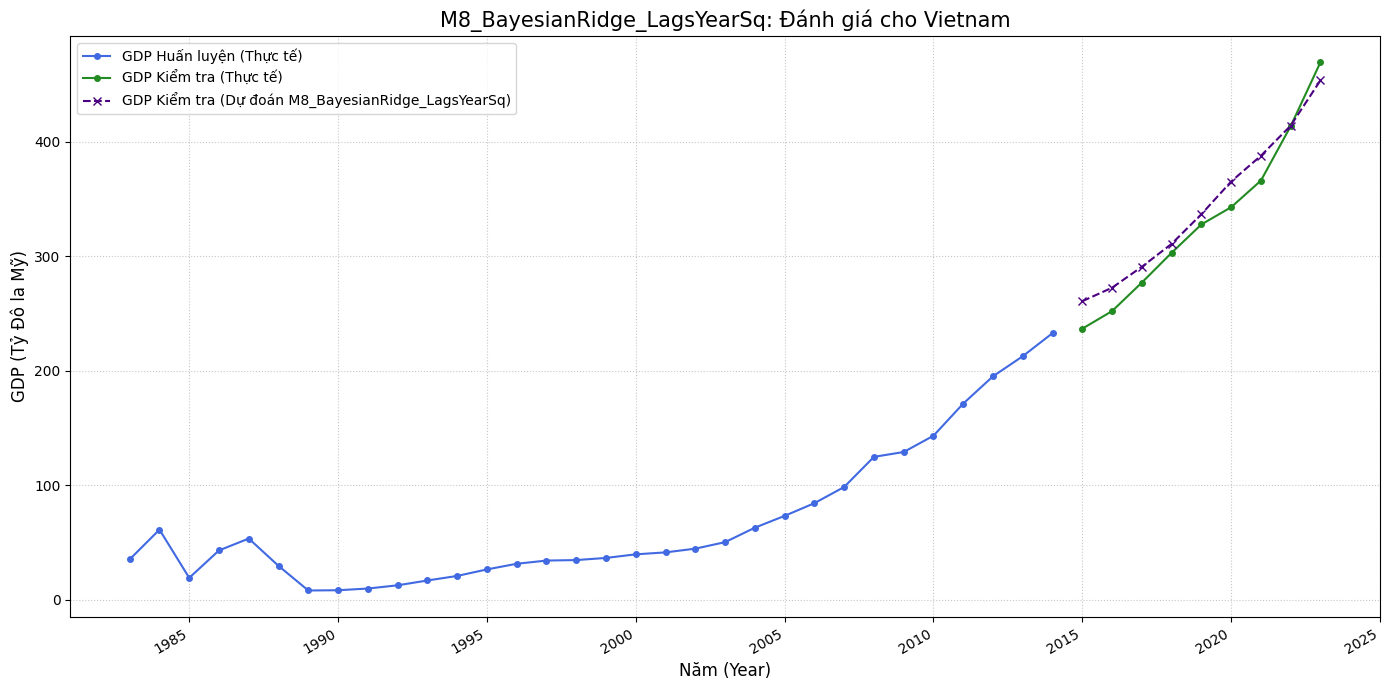

In [18]:
# --- CELL BR3.M8: {MODEL_ID_M8} - ĐÁNH GIÁ MÔ HÌNH ---

r2_br_m8, mae_br_m8, rmse_br_m8, mape_br_m8 = np.nan, np.nan, np.nan, np.nan
y_pred_test_m8 = None; y_pred_train_m8 = None

if 'model_br_m8' in locals() and model_br_m8 is not None and \
   'X_train_scaled_m8' in locals() and X_train_scaled_m8 is not None and \
   'X_test_scaled_m8' in locals() and X_test_scaled_m8 is not None and \
   'y_train_m8' in locals() and y_train_m8 is not None and \
   'y_test_m8' in locals() and y_test_m8 is not None and not y_test_m8.empty:
    
    y_pred_train_m8 = model_br_m8.predict(X_train_scaled_m8)
    y_pred_test_m8 = model_br_m8.predict(X_test_scaled_m8)

    print(f"\n--- {MODEL_ID_M8}: Đánh giá trên tập Huấn luyện ---")
    r2_train_m8 = r2_score(y_train_m8, y_pred_train_m8)
    mae_train_m8 = mean_absolute_error(y_train_m8, y_pred_train_m8)
    rmse_train_m8 = np.sqrt(mean_squared_error(y_train_m8, y_pred_train_m8))
    try:
        mape_train_m8 = np.mean(np.abs((y_train_m8 - y_pred_train_m8) / (y_train_m8 + 1e-9))) * 100
        print(f"R2: {r2_train_m8:.4f}, MAE: {mae_train_m8:.2f}, RMSE: {rmse_train_m8:.2f}, MAPE: {mape_train_m8:.2f}%")
    except Exception as e: print(f"R2: {r2_train_m8:.4f}, MAE: {mae_train_m8:.2f}, RMSE: {rmse_train_m8:.2f}, Lỗi MAPE: {e}")

    print(f"\n--- {MODEL_ID_M8}: Đánh giá trên tập Kiểm tra ---")
    r2_br_m8 = r2_score(y_test_m8, y_pred_test_m8)
    mae_br_m8 = mean_absolute_error(y_test_m8, y_pred_test_m8)
    rmse_br_m8 = np.sqrt(mean_squared_error(y_test_m8, y_pred_test_m8))
    
    y_true_m = y_test_m8.copy(); y_pred_m = pd.Series(y_pred_test_m8, index=y_true_m.index)
    zero_mask = (np.abs(y_true_m) < 1e-9)
    y_true_f = y_true_m[~zero_mask]; y_pred_f = y_pred_m[~zero_mask]
    if len(y_true_f) > 0: mape_br_m8 = np.mean(np.abs((y_true_f - y_pred_f) / y_true_f)) * 100
    else: mape_br_m8 = np.nan
            
    print(f"R-squared (Test): {r2_br_m8:.4f}")
    print(f"MAE (Test): {mae_br_m8:.2f}")
    print(f"RMSE (Test): {rmse_br_m8:.2f}")
    if not np.isnan(mape_br_m8): print(f"MAPE (Test): {mape_br_m8:.2f}% (Tính trên {len(y_true_f)} điểm)")
    else: print("MAPE (Test): Không thể tính.")

    plt.figure(figsize=(14, 7))
    if 'years_train_m8' in locals() and years_train_m8 is not None:
        plt.plot(years_train_m8, y_train_m8, label='GDP Huấn luyện (Thực tế)', color='royalblue', marker='o', markersize=4)
    if 'years_test_m8' in locals() and years_test_m8 is not None:
        plt.plot(years_test_m8, y_test_m8, label='GDP Kiểm tra (Thực tế)', color='forestgreen', marker='o', markersize=4)
        plt.plot(years_test_m8, y_pred_test_m8, label=f'GDP Kiểm tra (Dự đoán {MODEL_ID_M8})', color='indigo', marker='x', markersize=6, linestyle='--')
    plt.title(f'{MODEL_ID_M8}: Đánh giá cho {COUNTRY_M8}', fontsize=15)
    plt.xlabel('Năm (Year)', fontsize=12); plt.ylabel('GDP (Tỷ Đô la Mỹ)', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
else:
    print(f"Mô hình {MODEL_ID_M8} chưa được huấn luyện hoặc không có dữ liệu test/train để đánh giá.")



--- M8_BayesianRidge_LagsYearSq: PHÂN TÍCH PHẦN DƯ CHO VIETNAM ---


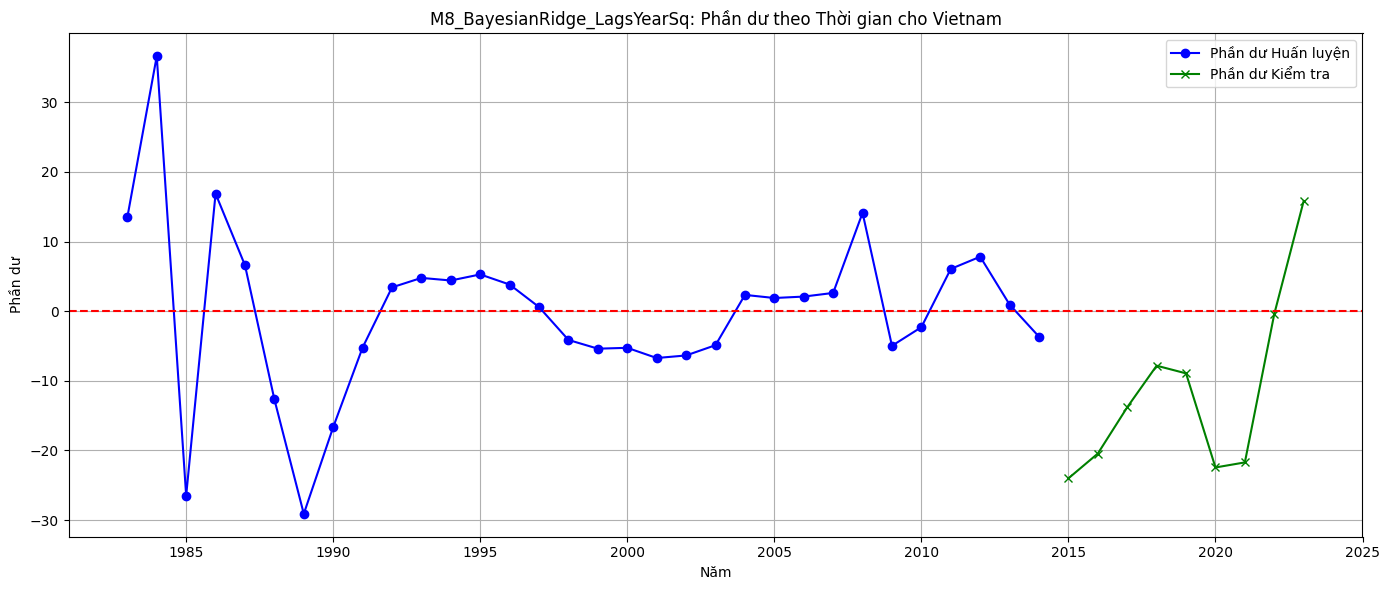

In [19]:
# --- CELL BR4.M8: {MODEL_ID_M8} - PHÂN TÍCH PHẦN DƯ ---
if 'model_br_m8' in locals() and model_br_m8 is not None and \
   'y_train_m8' in locals() and y_train_m8 is not None and 'y_pred_train_m8' in locals() and y_pred_train_m8 is not None and \
   'y_test_m8' in locals() and y_test_m8 is not None and 'y_pred_test_m8' in locals() and y_pred_test_m8 is not None:
    
    print(f"\n\n--- {MODEL_ID_M8}: PHÂN TÍCH PHẦN DƯ CHO {COUNTRY_M8.upper()} ---")
    residuals_train_m8 = y_train_m8 - y_pred_train_m8
    residuals_test_m8 = y_test_m8 - y_pred_test_m8

    # (Code vẽ các biểu đồ phần dư tương tự như các mô hình trước, thay hậu tố)
    plt.figure(figsize=(14, 6))
    if 'years_train_m8' in locals() and years_train_m8 is not None:
        plt.plot(years_train_m8, residuals_train_m8, marker='o', linestyle='-', color='blue', label='Phần dư Huấn luyện')
    if 'years_test_m8' in locals() and years_test_m8 is not None and not residuals_test_m8.empty:
        plt.plot(years_test_m8, residuals_test_m8, marker='x', linestyle='-', color='green', label='Phần dư Kiểm tra')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Năm'); plt.ylabel('Phần dư')
    plt.title(f'{MODEL_ID_M8}: Phần dư theo Thời gian cho {COUNTRY_M8}'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    # Thêm các biểu đồ khác: Residuals vs Predicted, Histogram, Q-Q
else:
    print(f"Mô hình {MODEL_ID_M8} chưa có đủ kết quả để phân tích phần dư.")